# Training with Original + Augmented images

## 1. Setup

In [37]:
# Better error messages in notebooks
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Set up data paths

import sys
from pathlib import Path

# Get to project root from notebook location
PROJECT_ROOT = Path.cwd().parent
# Add "src" to Python's module search path sys.path
sys.path.append(str(PROJECT_ROOT / "src"))

# Define project paths
#DATA_DIR = PROJECT_ROOT / "data"
DATA_DIR = PROJECT_ROOT / "data"
CONFIG_DIR = PROJECT_ROOT / "configs"
RUNS_DIR = PROJECT_ROOT / "runs"

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_DIR: {DATA_DIR}")
print(f"CONFIG_DIR: {CONFIG_DIR}")
print(f"RUNS_DIR: {RUNS_DIR}")

PROJECT_ROOT: /home/peterm/UWA/CITS5014/SARFish/modelling
DATA_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/data
CONFIG_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/configs
RUNS_DIR: /home/peterm/UWA/CITS5014/SARFish/modelling/runs


In [56]:
# Setup and imports
%matplotlib inline
#from sar_dataset import SARPreprocessedDataset
#from letterbox_resize import letterbox_resize
from sar_yolo_simple_trainer_v2 import SimpleSARTrainerV2
from sar_evaluator import SARFloat32Evaluator
import json

In [57]:
# Create data configuration
import yaml

data_config = {
    'path':   str(PROJECT_ROOT / 'data'), 
    'train':  'train_hvrt_60_40_alt',
    'val':    'val_alt', 
    'test':   'test_alt',
    'nc': 2,
    'names':  ['is_vessel', 'is_fishing']
}

# Save to configs directory
config_path = CONFIG_DIR / 'sar_data_alt.yaml'
with open(config_path, 'w') as f:
    yaml.dump(data_config, f)

## 2. Model Inspection (YOLOv8)

In [58]:
#%run {PROJECT_ROOT / 'src/yolov8n_model_explorer'}

### Proposed Freezing Strategies:

For YOLOv8n fine-tuning on SAR data:

1. CONSERVATIVE (Freeze backbone only):  
   Freezes modules 0-9
   - Freezes: 1,272,656 parameters (40.3%)
   - Trains: 1,884,544 parameters (59.7%)  
2. MODERATE (Freeze backbone + early neck):  
   Freezes modules 0-12  
3. AGGRESSIVE (Freeze most, train detection head only):  
   Freezes modules 0-20

## 3. Model training

In [59]:
%load_ext tensorboard
%tensorboard --logdir /home/peterm/UWA/CITS5014/SARFish/modelling/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 1618), started 2 days, 5:55:31 ago. (Use '!kill 1618' to kill it.)

In [51]:
# Initialise trainer
trainer = SimpleSARTrainerV2(
    model_name='yolov8n.pt',
    data_yaml=str(CONFIG_DIR / 'sar_data_alt.yaml'),
    imgsz=640,
    device='cuda',
    save_dir=RUNS_DIR / 'train_aug_alt'
)

Using device: cuda
Models will be saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_aug_alt/20250809_135747
Found 7773 image-label pairs
Found 463 image-label pairs
Train samples: 7773
Val samples: 463


### Alternative processing: single-phase, augmented, float32 numpy array dataset

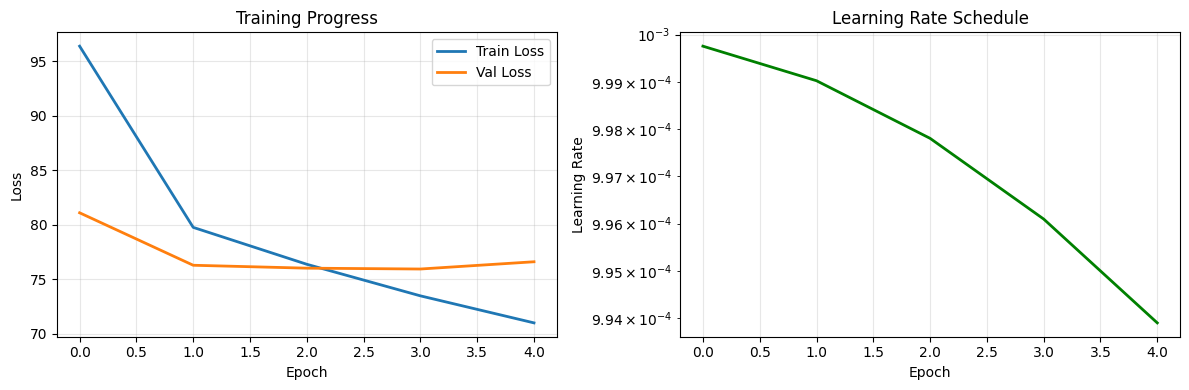


Epoch 6/100


Training:   0%|          | 0/486 [00:00<?, ?it/s]

In [ ]:
history = trainer.train(
    epochs=100,
    batch_size=16,
    lr=0.001,  # SGD, Cosine LR schedule
    workers=8,
    weight_decay=0.0005
)

Two-Phase training:

In [7]:
# Initialise trainer
trainer = SimpleSARTrainer(
    model_name='yolov8n.pt',
    data_yaml=str(CONFIG_DIR / 'sar_data_rotate.yaml'),
    imgsz=640,
    device='cuda',
    save_dir=RUNS_DIR / 'train_rotate'
)

Models will be saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_rotate/20250804_203911
Using device: cuda
Train samples: 4687
Val samples: 463


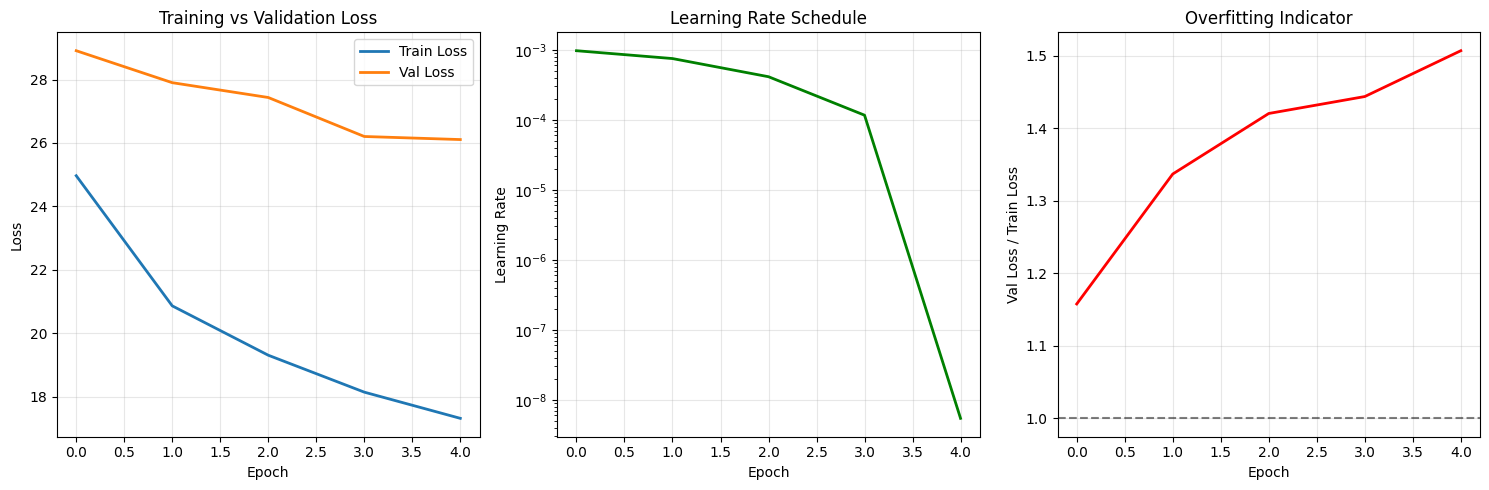

Saved checkpoint: final.pt

Training completed!
Best validation loss: 26.1077
Final epoch: 5


In [8]:
# Phase 1
history1 = trainer.train(
    epochs=5,                       # short trainng time
    batch_size=16,
    optimizer_type='adamw',
    lr=0.0001,                       # moderate learning rate
    workers=4,
    weight_decay=0.001,              # L2 regularization
    use_warmup=True,                 # Enable learning rate warmup & OneCycleLR scheduler
    use_progressive_unfreeze=False,  # Disable progressive unfreezing
    freeze_until_module=21           # Freeze module 0-21 (all except Detect layer)
)

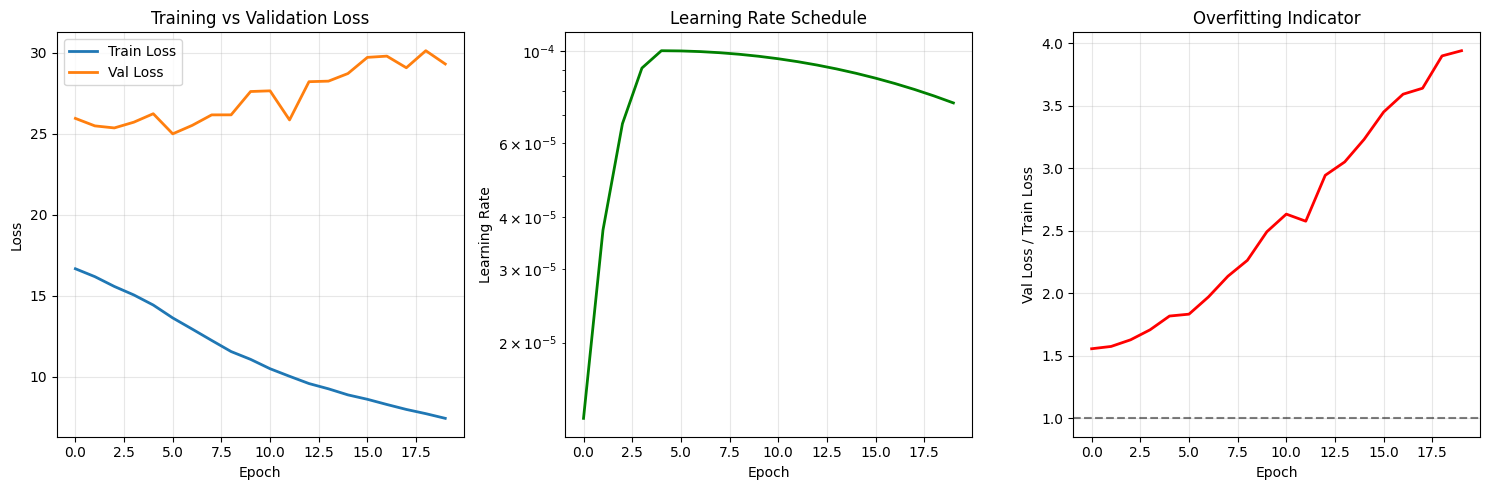

Saved checkpoint: epoch_20.pt

Epoch 21/50


Training:   0%|          | 0/331 [00:00<?, ?it/s]


Loss components - Box: 2.87, Cls: 3.52, DFL: 2.60

Loss components - Box: 1.88, Cls: 2.65, DFL: 2.07

Loss components - Box: 1.81, Cls: 2.08, DFL: 2.15

Loss components - Box: 2.89, Cls: 3.85, DFL: 2.69

Loss components - Box: 2.09, Cls: 2.35, DFL: 2.35

Loss components - Box: 2.42, Cls: 2.67, DFL: 2.43

Loss components - Box: 0.45, Cls: 0.32, DFL: 0.30


Validation:   0%|          | 0/29 [00:00<?, ?it/s]


Results:
  Train Loss: 7.2095
  Val Loss: 30.1414
  Learning Rate: 0.000072
  ⏳ Patience counter: 15/15

🛑 Early stopping triggered at epoch 21
Saved checkpoint: final.pt

Training completed!
Best validation loss: 25.0071
Final epoch: 21


In [9]:
# Phase 2
trainer.patience_counter=0
trainer.early_stop_patience = 15 
# reset patience
history2 = trainer.train(
    epochs=50,                      # try for another 50 epochs
    batch_size=16,
    optimizer_type='adamw',
    lr=0.00001,                      # lower learning rate
    workers=4,
    weight_decay=0.001,              # L2 regularization
    use_warmup=True,                 # Enable learning rate warmup & OneCycleLR scheduler
    use_progressive_unfreeze=False,  # Disable progressive unfreezing
    freeze_until_module=16           # Freeze modules 0-16 (backbone + half of neck)
)

In [ ]:
# Load best model
best_epoch, best_val_loss = trainer.load_best_model()
print(f"Loaded best model from epoch {best_epoch+1} with val loss {best_val_loss:.4f}")

In [21]:
# Save training history using the trainer's save_dir
with open(trainer.save_dir / 'history.json', 'w') as f:
    json.dump(history, f)

# Save training config (MANUAL EDIT!)
config = {
    'model_name': 'yolov8n.pt',
    'epochs': 50,
    'batch_size': 16,
    'optimizer_type': 'adamw',
    'lr': 0.0001,
    'workers': 4,
    'weight_decay': 0.001,
    'use_warmup': True,
    'use_progressive_unfreeze': False,
    'freeze_until_module': 12,
    'best_val_loss': trainer.best_val_loss,
    'final_epoch': len(history['train_loss']),
    'early_stopped': trainer.patience_counter >= trainer.early_stop_patience
}

with open(trainer.save_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"✅ Saved training history and config to: {trainer.save_dir}")

✅ Saved training history and config to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/train_hvr_56_44/20250802_211010


## 4. Model Evaluation

In [6]:
# Sets up path to the relevant data.yaml file for easy access
config_path=CONFIG_DIR /'sar_data_hvr_56_44_alt.yaml' 
print(config_path)

/home/peterm/UWA/CITS5014/SARFish/modelling/configs/sar_data_hvr_56_44_alt.yaml


In [7]:
# Initialize the evaluator
evaluator = SARFloat32Evaluator(
    model_path=RUNS_DIR / 'train_hvr_56_44_alt/20250803_212706/best.pt',
    data_yaml_path=config_path,
    device='cuda'
)

In [18]:
# Create the test dataset
with open(config_path, 'r') as f:
    data_dict = yaml.safe_load(f)

# Create test dataset manually
data_root = Path(data_dict['path'])
test_dataset = SARPreprocessedDataset(
    image_dir=str(data_root / 'test' / 'images_alt_proc'),  # or 'val' if using val
    label_dir=str(data_root / 'test' / 'labels'),
    imgsz=640
)

In [19]:
# Run evaluation
metrics = evaluator.evaluate_dataset(
    test_dataset,
    batch_size=32,
    conf_thres=0.25,
    iou_thres=0.45,
    save_dir=RUNS_DIR / 'evaluation_hvr_56_44_alt' / 'test_results'
)

Evaluating on 253 images...


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.25it/s]



Results saved to: /home/peterm/UWA/CITS5014/SARFish/modelling/runs/evaluation_hvr_56_44_alt/test_results
- metrics.json: Detailed metrics
- evaluation_results.png: Visualization


In [ ]:
# Test inference on a single image
import torch
import numpy as np

# Load a test image
test_img_path = list((DATA_DIR / 'test' / 'images').glob('*.npy'))[0]
print(test_img_path)
test_img = np.load(test_img_path)

# Convert numpy image to a torch tensor and add a batch dimension with
# unsqueeze, then move the tensor to the approriate device (CPU or GPU)
test_img = torch.from_numpy(test_img).unsqueeze(0).to(trainer.device)

# Run inference
trainer.model.eval() # Sets the model to evaluation mode (disables dropout, uses running stats for batch normalization)
with torch.no_grad(): # Disables gradient computation for efficiency during inference
    predictions = trainer.model(test_img)

# Print the shape of predictions—taking care to handle tuple output (like in YOLO-style heads).    
print(f"Predictions shape: {predictions[1][0].shape if isinstance(predictions, tuple) else predictions.shape}")